# Anomly Detection Training tcnae

## Util Function

### Import Lib

In [6]:
# Import the libraries
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model,save_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation,Flatten, LSTM, TimeDistributed, RepeatVector,GRU, Input, ConvLSTM2D, Bidirectional,BatchNormalization
from tensorflow.keras import Input
#from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import math
import json
from IPython.core.pylabtools import figsize

figsize(15, 7) 

### Utils

In [7]:
def read_data(path,o_dtname="Datetime",c_dtname = 'datetime',names=None,skiprows=None):
    df = pd.read_csv(path, sep=',', 
                     parse_dates={c_dtname:[o_dtname]}, 
                     infer_datetime_format=True, 
                     low_memory=False, 
                     na_values=['nan','?'], 
                     index_col=c_dtname,
                     names=names,
                    skiprows=skiprows)

    #df = df.reindex(index=df.index[:,:-1])
    print(df.isnull().sum())
    # filling nan with mean in any columns
    #for j in range(df.shape[1]):        
        #df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())
        
    #df.iloc[:,4:] = df.iloc[:,4:]*100
    #another sanity check to make sure that there are not more any nan
    #print(df.isnull().sum())
    #print(df.head())
    return df
#draw_trend
def draw_trend(df,groups,bound=200):
    #figsize(15,10) 
    
    anomly_df = df.copy()
    anomly_df[anomly_df>0] = np.nan
    
    i=1
    Values = df.values
    Anomaly = anomly_df.values
    cols = groups
    
    for group in groups:
        plt.subplot(len(cols), 1, i)
        plt.plot(Values[:bound, group],linewidth=3)
        plt.plot(Anomaly[:bound, group],color='red',linewidth=8)
        plt.title(df.columns[group], y=0.80, loc='right')
        #plt.xticks(range(0,4020,20))
        i += 1
    plt.show()
    print('\n')

def draw_trend_resample(df,groups,resample_freq,bound=200):
    #figsize(15,10) 
    i=1
    Values = df.resample(resample_freq).mean().values
    cols = groups
    for group in groups:
        plt.subplot(len(cols), 1, i)
        plt.plot(Values[:bound, group],linewidth=3)
        #plt.xticks(range(0,bound+10,10))
        plt.title(df.columns[group]+' resample-{}'.format(resample_freq), y=0.80, loc='right')
        i += 1
    plt.tight_layout()
    plt.show()
    
    print('\n')
#draw_corr
def show_corr(df,group):
    plt.matshow(df.iloc[:,group].corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
    plt.title('Spearman_original', size=15)
    plt.xticks(range(len(group)),labels=map(str,group))
    plt.yticks(range(len(group)),labels=map(str,group))
    plt.colorbar()
    plt.show()
    
def show_corr_resample(df,group,resample_freq):
    plt.matshow(df.resample(resample_freq).mean().iloc[:,group].corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
    plt.title('Spearman_resample-{}'.format(resample_freq), size=15)
    plt.xticks(range(len(group)),labels=map(str,group))
    plt.yticks(range(len(group)),labels=map(str,group))
    plt.colorbar()
    plt.show()
    

In [8]:
from scipy import stats
def gen_dataset(data,x_window_size,y_window_size):
    X_train = []   #預測點的前 60 天的資料
    y_train = []   #預測點
    for i in range(x_window_size, data.shape[0]-y_window_size,y_window_size):
        X_train.append(data.iloc[i-x_window_size:i, :-1].values)
        
        if np.sum(data.iloc[i-x_window_size:i, -1].values) >= 1:
            y_train.append(1)
        else:
            y_train.append(0)

    X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN
    
    #X_train = np.reshape(X_train, (X_train.shape[0], x_window_size,data.shape[1] ))

    """if y_window_size == 1:
        y_train = np.reshape(y_train,(y_train.shape[0], y_train.shape[2]))
    else:
        y_train = np.reshape(y_train,(y_train.shape[0],y_window_size,y_train.shape[2]))"""
        
    print("Gen data info:")
    print("X_data_shape:{}".format(X_train.shape))
    print("y_data_shape:{}".format(y_train.shape))
    print("\n")
          
    return X_train,y_train

def data_scaling(data,X_win_size,y_win_size,mode='robust'):
    
    assert mode == 'robust' or mode == 'minmax','Wrong mode name'
    print("Mode:{}\n".format(mode))
    print(data.describe())
    
    #Record training data index
    data_index = data.shape[0]
   
    # Feature Scaling
    from sklearn.preprocessing import MinMaxScaler,RobustScaler
    if mode =='robust':
         #RobustScaler
        scaler = RobustScaler()
        data[list(data.columns)[:-1]] = scaler.fit_transform(data[list(data.columns)[:-1]])     
    elif mode == 'minmax':        
        #MinMaxScaler
        scaler = MinMaxScaler()
        data.iloc[:,:-1] = scaler.fit_transform(data.iloc[:,:-1])     
    
    print(data.describe())
    #generate dataset
    data_X,data_y = gen_dataset(data,X_win_size,y_win_size)
    
    return data_X,data_y,scaler,data,scaler.get_params()


## Training Proccess

### Read Data

# Test df

In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], 
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4500)])
    except RuntimeError as e:
        print(e)

CPU utilization (%)                               0
Disk (0 C:) - % Disk saturation                   0
Disk (0 C:) - % Idle Time                         0
Disk (0 C:) - Average Disk Bytes Read             0
Disk (0 C:) - Average Disk Bytes Total            0
Disk (0 C:) - Average Disk Bytes Write            0
Disk (0 C:) - Avg. Disk sec/Read (Latency)        0
Disk (0 C:) - Avg. Disk sec/Transfer (Latency)    0
Disk (0 C:) - Avg. Disk sec/Write (Latency)       0
Disk (1 D:) - % Disk saturation                   0
Disk (1 D:) - % Idle Time                         0
Disk (1 D:) - Average Disk Bytes Read             0
Disk (1 D:) - Average Disk Bytes Total            0
Disk (1 D:) - Average Disk Bytes Write            0
Disk (1 D:) - Avg. Disk sec/Read (Latency)        0
Disk (1 D:) - Avg. Disk sec/Transfer (Latency)    0
Disk (1 D:) - Avg. Disk sec/Write (Latency)       0
Memory used  (%)                                  0
C_anomaly_label                                   0
dtype: int64

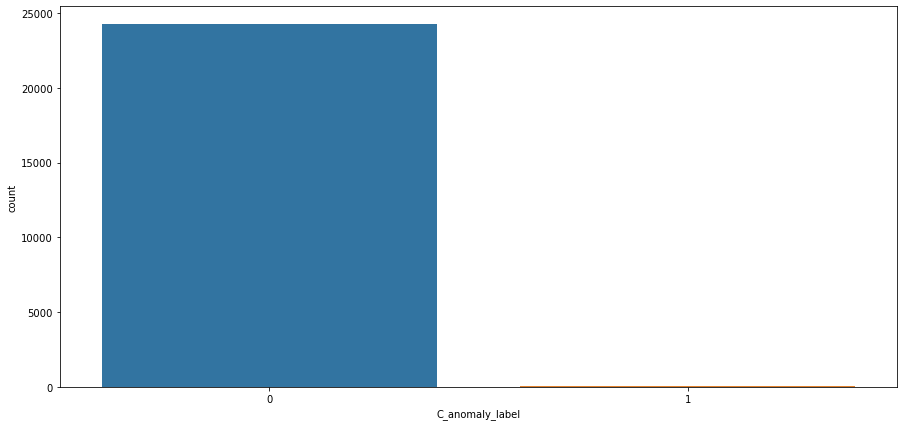

1098
Mode:minmax

       CPU utilization (%)  Memory used  (%)  C_anomaly_label
count          1220.000000       1220.000000           1220.0
mean             79.939104         78.391564              0.0
std               5.247382          4.985863              0.0
min              61.393567         52.730945              0.0
25%              76.489488         76.078063              0.0
50%              77.318286         79.324929              0.0
75%              83.616809         81.176825              0.0
max              98.181555         97.898486              0.0
       CPU utilization (%)  Memory used  (%)  C_anomaly_label
count          1220.000000       1220.000000           1220.0
mean              0.504119          0.568121              0.0
std               0.142638          0.110386              0.0
min               0.000000          0.000000              0.0
25%               0.410349          0.516900              0.0
50%               0.432878          0.588785        

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


Gen data info:
X_data_shape:(235, 16, 2)
y_data_shape:(235,)


Mode:minmax

       CPU utilization (%)  Memory used  (%)  C_anomaly_label
count           740.000000        740.000000       740.000000
mean             80.639458         74.799159         0.014865
std               5.502306          6.806310         0.121094
min              62.174300         52.667300         0.000000
25%              76.315019         71.218167         0.000000
50%              78.453217         75.985756         0.000000
75%              84.284042         78.940838         0.000000
max              99.533822         96.105438         1.000000
       CPU utilization (%)  Memory used  (%)  C_anomaly_label
count           740.000000        740.000000       740.000000
mean              0.494256          0.509503         0.014865
std               0.147280          0.156690         0.121094
min               0.000000          0.000000         0.000000
25%               0.378504          0.427064         0.0

In [19]:
from sklearn.model_selection import train_test_split
import seaborn as sns

X_WIN = 16
Y_WIN = 1
SCALE_MODE = 'minmax'
select_col = ["CPU utilization (%)","Memory used  (%)","C_anomaly_label"]
def anomaly_map(x):
    label = 1 if x >0 else 0
    return label

#data["gender"] = data["gender"].map(gender_map)

#label count
df = read_data("6Vdata_diskio.csv",o_dtname="datetime",c_dtname = 'dt')
sns.countplot(x = 'C_anomaly_label',
              data = df,
              order = df.C_anomaly_label.value_counts().index)
plt.show()

#test data
test_df = df.loc["2021-10-25 12":"2021-10-27 00",select_col].resample("3min").mean()
test_df['C_anomaly_label'] = test_df['C_anomaly_label'].map(anomaly_map)

#
df1 = df.loc[:"2021-10-25 12",select_col].resample("3min").mean()
df1['C_anomaly_label'] = df1['C_anomaly_label'].map(anomaly_map)
df2 = df.loc["2021-10-27 00":,select_col].resample("3min").mean()
df2['C_anomaly_label'] = df2['C_anomaly_label'].map(anomaly_map)

print(int(df1.shape[0]*0.9))
x_val1 = df1.iloc[int(df1.shape[0]*0.8):,:]
x_val2 = df2.iloc[int(df2.shape[0]*0.8):,:]


df1_X, df1_y, scaler,df_scale,param = data_scaling(df1,X_WIN,Y_WIN,mode=SCALE_MODE)
df2_X, df2_y, scaler,df_scale,param = data_scaling(df2,X_WIN,Y_WIN,mode=SCALE_MODE)
x_val1_X, x_val1_y, scaler,df_scale,param = data_scaling(x_val1,X_WIN,Y_WIN,mode=SCALE_MODE)
x_val2_X,x_val2_y, scaler,df_scale,param = data_scaling(x_val2,X_WIN,Y_WIN,mode=SCALE_MODE)
X_test,y_test, scaler,df_scale,param = data_scaling(test_df,X_WIN,Y_WIN,mode=SCALE_MODE)


X_train = np.concatenate([df1_X,df2_X],axis=0)
X_val = np.concatenate([x_val1_X,x_val2_X],axis=0)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

## save test data

In [34]:
test_df.to_csv("test_df.csv")
np.save("X_test.npy",X_test)
np.save("y_test.npy",y_test)

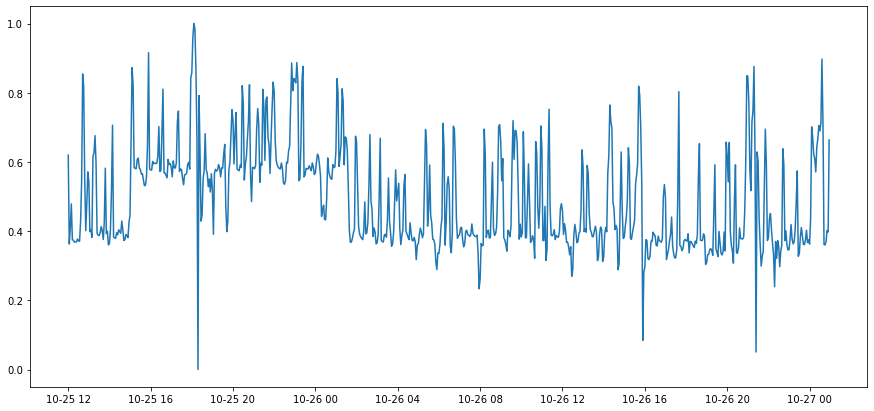

In [35]:
plt.plot(test_df["CPU utilization (%)"])

In [23]:
test_df.resample("5min").mean()

,CPU utilization (%),Memory used (%),C_anomaly_label
dt,,,
2021-10-25 12:00:00,0.731770,0.732290,0.0
2021-10-25 12:05:00,0.570751,0.352047,0.0
2021-10-25 12:10:00,0.622660,0.403994,0.0
2021-10-25 12:15:00,0.558652,0.407991,0.0
2021-10-25 12:20:00,0.554917,0.419423,0.0
...,...,...,...
2021-10-27 00:35:00,0.871146,0.521124,0.0
2021-10-27 00:40:00,0.758068,0.458251,0.0
2021-10-27 00:45:00,0.549062,0.205543,0.0


### Save Scaler pickle

In [7]:
from pickle import dump

#dump(scaler, open('5v_scaler.pkl', 'wb'))
dump(scaler, open('6v_minmax_scaler.pkl', 'wb'))

### Train Simple conv_ae

In [ ]:
input_sig = Input(batch_shape=(1,128,1))
x = Conv1D(8,3, activation='relu', padding='same',dilation_rate=2)(input_sig)
x1 = MaxPooling1D(2)(x)
x2 = Conv1D(4,3, activation='relu', padding='same',dilation_rate=2)(x1)
x3 = MaxPooling1D(2)(x2)
x4 = AveragePooling1D()(x3)
flat = Flatten()(x4)
encoded = Dense(2)(flat)
d1 = Dense(64)(encoded)
d2 = Reshape((16,4))(d1)
d3 = Conv1D(4,1,strides=1, activation='relu', padding='same')(d2)
d4 = UpSampling1D(2)(d3)
d5 = Conv1D(8,1,strides=1, activation='relu', padding='same')(d4)
d6 = UpSampling1D(2)(d5)
d7 = UpSampling1D(2)(d6)
decoded = Conv1D(1,1,strides=1, activation='sigmoid', padding='same')(d7)
model= Model(input_sig, decoded)


### Run no. 1
Shape of Z: (None, 152)

 TBVAE-20210917-015918:
str=3
c=36
l=3
f1=38
k1=2
dilr=[1]
p=4.07e+04
eps=10
pat=35 

(18520, 32, 2)
(18520, 32, 2)
(18520, 32, 2)
(18520, 32, 2)


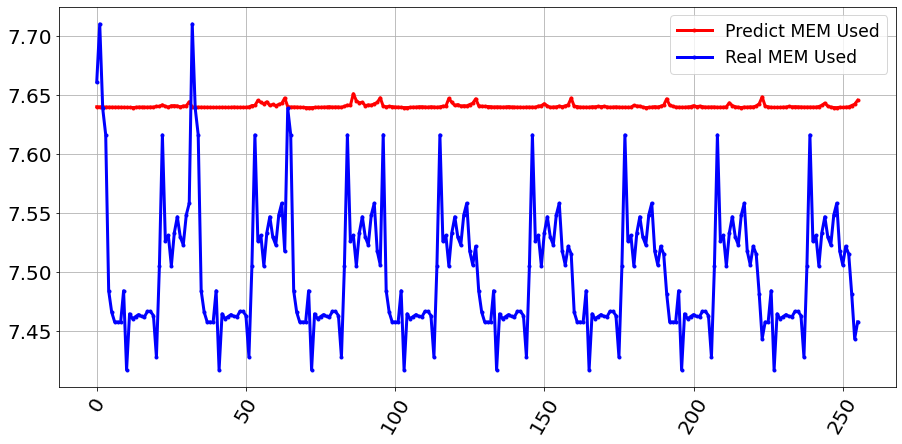


### Run no. 2
Shape of Z: (None, 1776)

 TBVAE-20210917-015938:
str=7
c=17
l=1
f1=111
k1=6
dilr=[1]
p=2.46e+05
eps=10
pat=49 

(18520, 32, 2)
(18520, 32, 2)
(18520, 32, 2)
(18520, 32, 2)


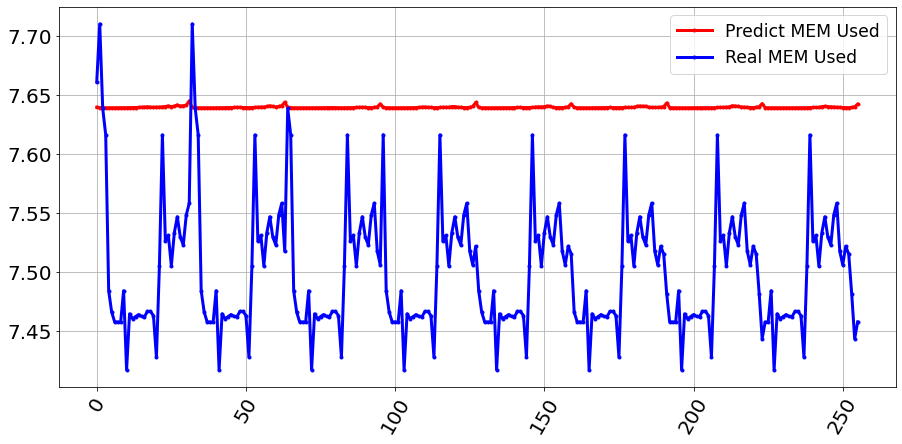


### Run no. 3
Shape of Z: (None, 352)

 TBVAE-20210917-015952:
str=5
c=34
l=3
f1=88
k1=2
dilr=[1]
p=1.62e+05
eps=10
pat=33 

(18520, 32, 2)
(18520, 32, 2)
(18520, 32, 2)
(18520, 32, 2)


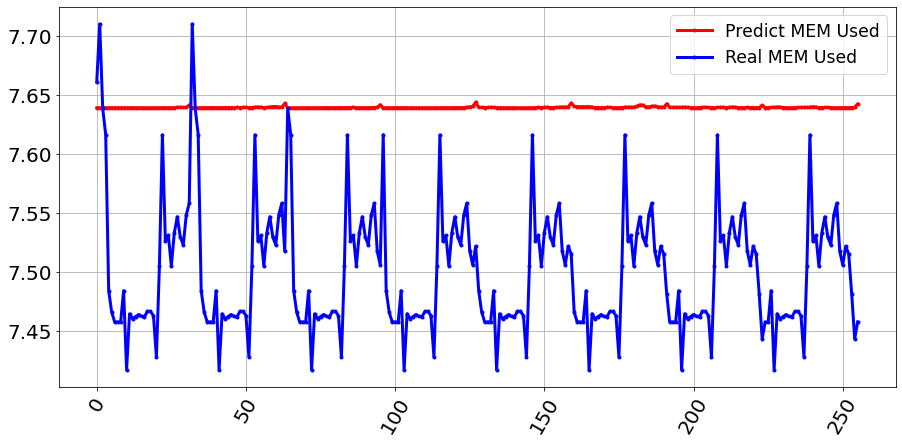


### Run no. 4
Shape of Z: (None, 552)

 TBVAE-20210917-020012:
str=5
c=8
l=2
f1=69
k1=6
dilr=[1]
p=1.60e+05
eps=10
pat=38 

(18520, 32, 2)
(18520, 32, 2)
(18520, 32, 2)
(18520, 32, 2)


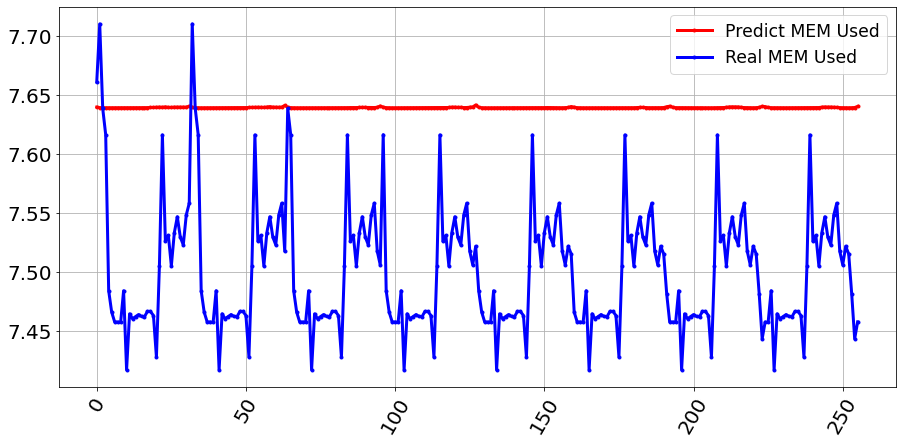


### Run no. 5
Shape of Z: (None, 96)

 TBVAE-20210917-020028:
str=3
c=27
l=3
f1=24
k1=5
dilr=[1]
p=3.20e+04
eps=10
pat=31 

(18520, 32, 2)
(18520, 32, 2)
(18520, 32, 2)
(18520, 32, 2)


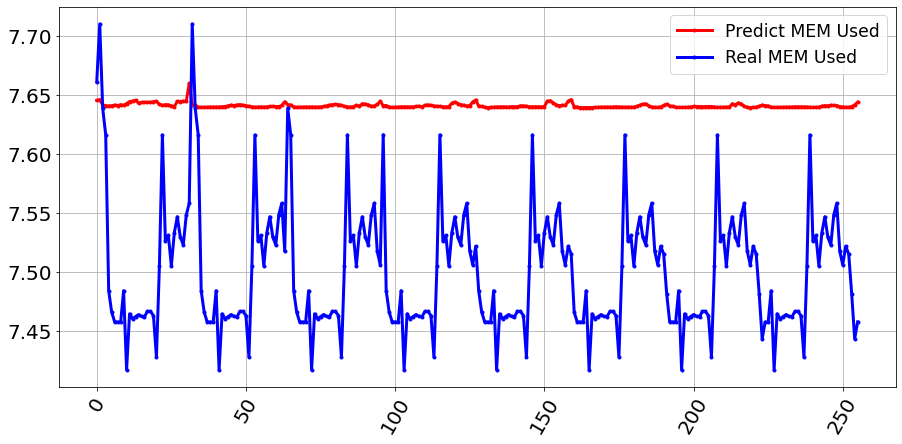

In [75]:
from sklearn.utils import shuffle
from sklearn.model_selection import ParameterSampler
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
import traceback,datetime
import numpy as np
import pandas as pd
import TCN_VAE,os,AE_Conv 
import importlib
importlib.reload(AE_Conv)

# Input the number of iterations you want to search over
random_search_iterations = 5

# random seed value from system input
ransdom_seed_input = 135

# parameters for beta-vae
conv_ae_grid = {
    "codings_size": sp_randint(5, 40),
    "conv_layers": [3, 2, 1],
    "start_filter_no": sp_randint(16, 128),
    "dilation_rate": [[1]],
    "kernel_size_1": sp_randint(2, 9),
    "earlystop_patience": sp_randint(30, 50),
    "strides":sp_randint(1,8),   
}

# epochs
epochs = 10

# folder to save models in
model_save_folder = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'_mill'

# create the folder
os.mkdir("Model/CONV_AE_saved_models/{}".format(model_save_folder))
#(folder_models / 'saved_models' / model_save_folder).mkdir(parents=True, exist_ok=True)

# create dataframe to store all the results
df_all = pd.DataFrame()

# setup parameters to sample
rng = np.random.RandomState(ransdom_seed_input)

# list of parameters in random search
p_bvae = list(ParameterSampler(conv_ae_grid, n_iter=random_search_iterations,random_state=rng))


for i, params in enumerate(p_bvae):
    print('\n### Run no.', i+1)
    
    ### TRY MODELS ###

    # BETA-VAE
    # parameters  
    
    codings_size =params["codings_size"]
    conv_layers =params["conv_layers"]   
    start_filter_no =params["start_filter_no"] 
    kernel_size_1 = params["kernel_size_1"]
    dilation_rate = params["dilation_rate"]
    earlystop_patience=params["earlystop_patience"]
    stride = params["strides"]
    

    seed = 16
    verbose = 0

    # try the model and if it doesn't work, go onto the next model
    # not always the best to use 'try' but good enough
    try:

        date_time, model_name, history, conv_ae_model, conv_ae_encoder = AE_Conv.model_fit(
            X_train,
            X_test,
            codings_size=codings_size,
            conv_layers=conv_layers,
            seed=seed,
            start_filter_no=start_filter_no,
            strides=stride,
            kernel_size_1=kernel_size_1,
            dilation_rate=dilation_rate,
            epochs=epochs,
            earlystop_patience=earlystop_patience,
            verbose=verbose,
        )

        # save the model. How to: https://www.tensorflow.org/tutorials/keras/save_and_load
        # save model weights and model json
        model_save_dir_convae = os.path.join("Model/CONV_AE_saved_models/{}".format(model_save_folder),date_time + "_convae")
        """ model_save_dir_bvae = (
            folder_models / 'saved_models' / model_save_folder / (date_time + "_convae")
        ) """
        model_save_dir_encoder = os.path.join("Model/CONV_AE_saved_models/{}".format(model_save_folder),date_time + "_encoder")
        """ model_save_dir_encoder = (
            folder_models / 'saved_models' / model_save_folder / (date_time + "_encoder")
        ) """

        # create the save paths
        os.mkdir(model_save_dir_convae)
        os.mkdir(model_save_dir_encoder)
        #Path(model_save_dir_bvae).mkdir(parents=True, exist_ok=True)
        #Path(model_save_dir_encoder).mkdir(parents=True, exist_ok=True)

        # save entire bvae model
        model_as_json = conv_ae_model.to_json()
        with open(r"{}/model.json".format(str(model_save_dir_bvae)), "w",) as json_file:
            json_file.write(model_as_json)
        conv_ae_model.save_weights(str(model_save_dir_encoder) + "/weights.h5")

        # save encoder bvae model
        model_as_json = conv_ae_encoder.to_json()
        with open(r"{}/model.json".format(str(model_save_dir_encoder)), "w",) as json_file:
            json_file.write(model_as_json)
        conv_ae_encoder.save_weights(str(model_save_dir_encoder) + "/weights.h5")

        # get the model run history
        results = pd.DataFrame(history.history)
        epochs_trained = len(results)
        results["epochs_trained"] = epochs_trained
        results = list(
            results[results["val_loss"] == results["val_loss"].min()].to_numpy()
        )  # only keep the top result, that is, the lowest val_loss

        # append best result onto df_model_results dataframe
        if i == 0:
            cols = (
                list(p_bvae[0].keys())
                + list(history.history.keys())
                + ["epochs_trained"]
            )
            results = [[p_bvae[i][k] for k in p_bvae[i]] + list(results[0])]

        else:
            # create dataframe to store best result from model training
            cols = (
                list(p_bvae[0].keys())
                + list(history.history.keys())
                + ["epochs_trained"]
            )
            results = [[p_bvae[i][k] for k in p_bvae[i]] + list(results[0])]

        df = pd.DataFrame(results, columns=cols)

        df["date_time"] = date_time
        df["model_name"] = model_name

        df_all = df_all.append(df, sort=False)

        df_all.to_csv("results_interim_{}.csv".format(model_save_folder))
        
        conv_pre = conv_ae_model.predict(X_test)
        
        x_hat,x = concat_pre_data(conv_pre,X_test)
        
        
        x_hat,x = concat_pre_data(conv_pre,X_test)
        plt.plot(x_hat[:,0].flatten()[:256],color = 'red',marker='.', label = 'Predict MEM Used',linewidth=3)
        plt.plot(x[:,0].flatten()[:256],color = 'blue',marker='.', label = 'Real MEM Used',linewidth=3)
        plt.xticks(fontsize=20,rotation=60)
        plt.yticks(fontsize=20)
        plt.grid()
        plt.legend(fontsize='xx-large')
        #plt.title('Predicted values and actual values on test data',fontsize=20)
        plt.show()

        

    except Exception as e:
        print(e)
        print("TRACEBACK")
        traceback.print_exc()
        pass

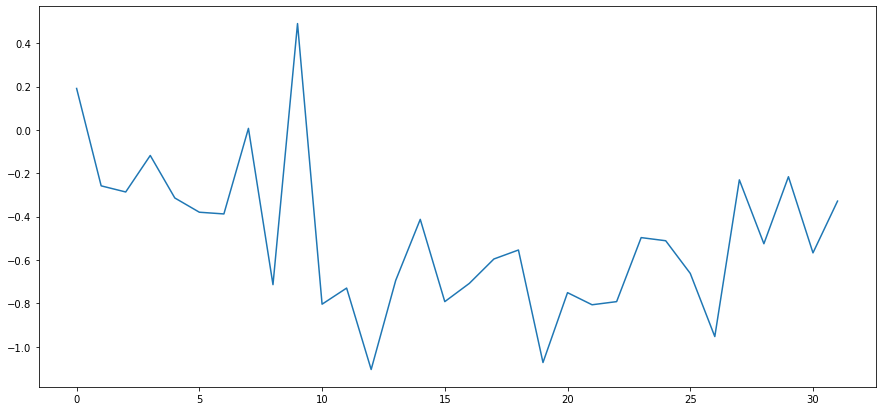

In [12]:
plt.plot(X_train[0,:,1])

## Random Search TCN_AE

In [11]:
def pre_proc(slide_window_size,scale_mode):
    SCALE_MODE = 'minmax'
    select_col = ["CPU utilization (%)","Memory used  (%)","C_anomaly_label"]
    
    def anomaly_map(x):
        label = 1 if x >0 else 0
        return label
    

    #label count
    df = read_data("6Vdata_diskio.csv",o_dtname="datetime",c_dtname = 'dt')
    sns.countplot(x = 'C_anomaly_label',
                  data = df,
                  order = df.C_anomaly_label.value_counts().index)
    plt.show()

    #test data
    test_df = df.loc["2021-10-25 12":"2021-10-27 00",select_col].resample("3min").mean()
    test_df['C_anomaly_label'] = test_df['C_anomaly_label'].map(anomaly_map)

    #
    df1 = df.loc[:"2021-10-25 12",select_col].resample("3min").mean()
    df1['C_anomaly_label'] = df1['C_anomaly_label'].map(anomaly_map)
    df2 = df.loc["2021-10-27 00":,select_col].resample("3min").mean()
    df2['C_anomaly_label'] = df2['C_anomaly_label'].map(anomaly_map)

    print(int(df1.shape[0]*0.9))
    x_val1 = df1.iloc[int(df1.shape[0]*0.8):,:]
    x_val2 = df2.iloc[int(df2.shape[0]*0.8):,:]


    df1_X, df1_y, scaler,df_scale,param = data_scaling(df1,slide_window_size,Y_WIN,mode=scale_mode)
    df2_X, df2_y, scaler,df_scale,param = data_scaling(df2,slide_window_size,Y_WIN,mode=scale_mode)
    x_val1_X, x_val1_y, scaler,df_scale,param = data_scaling(x_val1,slide_window_size,Y_WIN,mode=scale_mode)
    x_val2_X,x_val2_y, scaler,df_scale,param = data_scaling(x_val2,slide_window_size,Y_WIN,mode=scale_mode)
    X_test,y_test, scaler,df_scale,param = data_scaling(test_df,slide_window_size,Y_WIN,mode=scale_mode)


    X_train = np.concatenate([df1_X,df2_X],axis=0)
    X_val = np.concatenate([x_val1_X,x_val2_X],axis=0)
    print(X_train.shape)
    print(X_val.shape)
    print(X_test.shape)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 2)]           0         
                                                                 
 tcn-enc (TCN)               (None, 32, 32)            506976    
                                                                 
 conv1d (Conv1D)             (None, 32, 8)             264       
                                                                 
 average_pooling1d (AverageP  (None, 2, 8)             0         
 ooling1D)                                                       
                                                                 
 activation (Activation)     (None, 2, 8)              0         
                                                                 
 up_sampling1d (UpSampling1D  (None, 32, 8)            0         
 )                                                           

Traceback (most recent call last):
  File "C:\Users\user\AppData\Local\Temp/ipykernel_74924/2190830588.py", line 101, in <module>
    history = tcn_ae.fit(X_train,X_train,batch_size=64,epochs=epochs,verbose=verbose,validation_data=X_val)
  File "E:\Server_mantain\Spark_test\bioma-tcn-ae-main\src\tcnae.py", line 159, in fit
    history = self.model.fit(train_X, train_Y,
  File "C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\tensorflow\python\framework\func_graph.py", line 1129, in autograph_handler
    raise e.ag_error_metadata.to_exception(e)
ValueError: in user code:

    File "C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\keras\engin

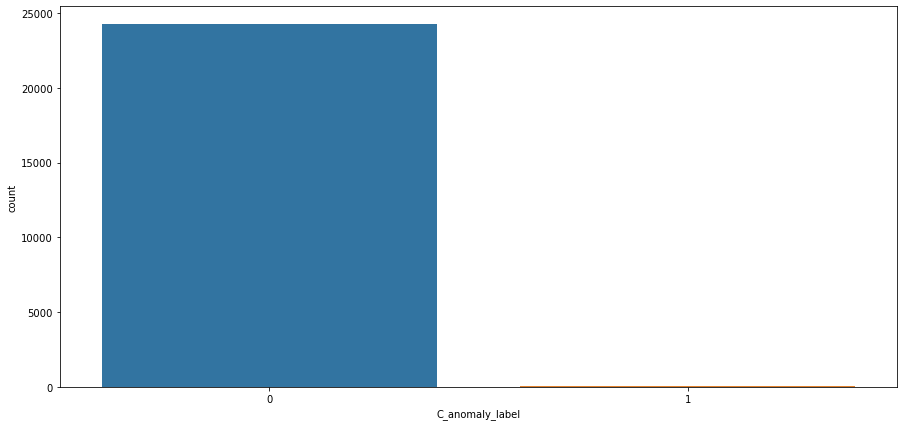

1098
Mode:minmax

       CPU utilization (%)  Memory used  (%)  C_anomaly_label
count          1220.000000       1220.000000           1220.0
mean             79.939104         78.391564              0.0
std               5.247382          4.985863              0.0
min              61.393567         52.730945              0.0
25%              76.489488         76.078063              0.0
50%              77.318286         79.324929              0.0
75%              83.616809         81.176825              0.0
max              98.181555         97.898486              0.0
       CPU utilization (%)  Memory used  (%)  C_anomaly_label
count          1220.000000       1220.000000           1220.0
mean              0.504119          0.568121              0.0
std               0.142638          0.110386              0.0
min               0.000000          0.000000              0.0
25%               0.410349          0.516900              0.0
50%               0.432878          0.588785        

KeyboardInterrupt: 

In [12]:
from sklearn.utils import shuffle
from sklearn.model_selection import ParameterSampler
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
import traceback,datetime
import numpy as np
import pandas as pd
import AE_TCN,os
import importlib
from IPython.display import clear_output
import seaborn as sns
importlib.reload(AE_TCN)
# Input the number of iterations you want to search over
random_search_iterations = 250

# random seed value from system input
ransdom_seed_input = 135

# parameters for beta-vae
"""
p_bvae_grid = {
    "latent_sample_rate": [2,4,8,16,32],
    "start_filter_no": [16,32,64,128],
    "nb_stacks": sp_randint(1, 5),
    "kernel_size_1": sp_randint(2, 20),
    "earlystop_patience": sp_randint(20, 50),
    "slide_window_size": [16,32,64],
    "scale_mode": ['robust','minmax']
}
"""
"""
p_bvae_grid = {
    "latent_sample_rate": [2],
    "start_filter_no": [16,32,64,128],
    "nb_stacks": sp_randint(1, 5),
    "kernel_size_1": [9],
    "earlystop_patience": sp_randint(20, 50),
    "slide_window_size": [16,32,64],
    "scale_mode": ['robust','minmax']
}
"""
# epochs
epochs = 100

# folder to save models in
model_save_folder = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'_mill'

# create the folder
os.mkdir("Model/TCNAE_saved_models/{}".format(model_save_folder))
#(folder_models / 'saved_models' / model_save_folder).mkdir(parents=True, exist_ok=True)

# create dataframe to store all the results
df_all = pd.DataFrame()

# setup parameters to sample
rng = np.random.RandomState(ransdom_seed_input)

# list of parameters in random search
p_bvae = list(ParameterSampler(p_bvae_grid, n_iter=random_search_iterations,random_state=rng))
Y_WIN = 1

for i, params in enumerate(p_bvae):
    print('\n### Run no.', i+1)
    
    ### TRY MODELS ###

    # BETA-VAE
    # parameters  
    
    latent_sample_rate =params["latent_sample_rate"] 
    start_filter_no =params["start_filter_no"] 
    kernel_size_1 = params["kernel_size_1"]
    nb_stacks = params["nb_stacks"]
    earlystop_patience = params["earlystop_patience"]
    slide_window_size = params["slide_window_size"]
    scale_mode = params["scale_mode"]
    

    seed = 16
    verbose = 1
    
    pre_proc(slide_window_size,scale_mode)
    clear_output(wait=True)
    


    # try the model and if it doesn't work, go onto the next model
    # not always the best to use 'try' but good enough
    try:

        tcn_ae = AE_TCN.TCNAE(ts_dimension=X_train.shape[2],
                              latent_sample_rate=latent_sample_rate,
                              nb_filters=start_filter_no,
                              kernel_size=kernel_size_1,
                              nb_stacks=nb_stacks,
                              earlystop_patience=earlystop_patience,
                              verbose=2,
                              window_size=slide_window_size)
        date_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        model_name = (
        "TCNAE-{}:_c={:.2f}_f={}_k={}_stk={}_er={}_win={}_scale={}".format(
            date_time,
            latent_sample_rate,
            start_filter_no,
            kernel_size_1,
            nb_stacks,
            earlystop_patience,
            slide_window_size,
            scale_mode
            )
        )
        print(model_name)
        history = tcn_ae.fit(X_train,X_train,batch_size=64,epochs=epochs,verbose=verbose,validation_data=X_val)
        
        # save the model. How to: https://www.tensorflow.org/tutorials/keras/save_and_load
        # save model weights and model json
        model_save_dir_tcnae = os.path.join("Model/TCNAE_saved_models/{}".format(model_save_folder),date_time + "_tcnae")
        # create the save paths
        os.mkdir(model_save_dir_tcnae)

        # save entire bvae model
        
        tcn_ae.save_model(str(model_save_dir_tcnae) + "/tcnae.h5")

        # save encoder bvae model
        """model_as_json = bvae_encoder.to_json()
        with open(r"{}/model.json".format(str(model_save_dir_encoder)), "w",) as json_file:
            json_file.write(model_as_json)
        bvae_encoder.save_weights(str(model_save_dir_encoder) + "/weights.h5")"""

        # get the model run history
        results = pd.DataFrame(history.history)
        epochs_trained = len(results)
        results["epochs_trained"] = epochs_trained
        results = list(
            results[results["val_loss"] == results["val_loss"].min()].to_numpy()
        )  # only keep the top result, that is, the lowest val_loss

        # append best result onto df_model_results dataframe
        if i == 0:
            cols = (
                list(p_bvae[0].keys())
                + list(history.history.keys())
                + ["epochs_trained"]
            )
            results = [[p_bvae[i][k] for k in p_bvae[i]] + list(results[0])]

        else:
            # create dataframe to store best result from model training
            cols = (
                list(p_bvae[0].keys())
                + list(history.history.keys())
                + ["epochs_trained"]
            )
            results = [[p_bvae[i][k] for k in p_bvae[i]] + list(results[0])]

        df = pd.DataFrame(results, columns=cols)

        df["date_time"] = date_time
        df["model_name"] = model_name

        df_all = df_all.append(df, sort=False)

        df_all.to_csv("./random_search_logs/TCN_AE/results_interim_{}.csv".format(model_save_folder))
        
        conv_pre = tcn_ae.predict(X_test)
        conv_pre = scaler.inverse_transform(conv_pre.reshape(-1,4)).reshape(-1,slide_window_size,4)

        for i in range(1,9,1):

            plt.subplot(4,2,i)
            plt.plot(conv_pre[i+1,:,0],color = 'red',marker='.', label = 'Predict MEM Used',linewidth=3)
            plt.plot(X_test[i+1,:,0],color = 'blue',marker='.', label = 'Real MEM Used',linewidth=3)
            plt.grid()
            plt.title("MEM",fontsize=10)

        
        plt.show()
        
        


    except Exception as e:
        print(e)
        print("TRACEBACK")
        traceback.print_exc()
        pass

## Random Search TCN_VAE

In [53]:
from sklearn.utils import shuffle
from sklearn.model_selection import ParameterSampler
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
import traceback,datetime
import numpy as np
import pandas as pd
import TCN_VAE,os 
import importlib
from IPython.display import clear_output

importlib.reload(TCN_VAE)


# Input the number of iterations you want to search over
random_search_iterations = 100

# random seed value from system input
ransdom_seed_input = 135

# parameters for beta-vae
p_bvae_grid = {
    "beta_value": uniform(loc=0.5, scale=9),
    "codings_size": sp_randint(5, 40),
    "conv_layers": [3, 2, 1],
    "start_filter_no": sp_randint(16, 256),
    "dilations": [[1, 2, 4, 8], [1, 2, 4], [1, 2]],
    "kernel_size_1": sp_randint(2, 9),
    "earlystop_patience": sp_randint(30, 50),
    "slide_window_size": [16,32,64],
    "scale_mode": ['robust','minmax']
    
}

# epochs
epochs = 100

# folder to save models in
model_save_folder = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'_mill'

# create the folder
os.mkdir("Model/TCN_saved_models/{}".format(model_save_folder))
#(folder_models / 'saved_models' / model_save_folder).mkdir(parents=True, exist_ok=True)

# create dataframe to store all the results
df_all = pd.DataFrame()

# setup parameters to sample
rng = np.random.RandomState(ransdom_seed_input)

# list of parameters in random search
p_bvae = list(ParameterSampler(p_bvae_grid, n_iter=random_search_iterations,random_state=rng))


for i, params in enumerate(p_bvae):
    print('\n### Run no.', i+1)
    
    ### TRY MODELS ###

    # BETA-VAE
    # parameters  
    beta_value =params["beta_value"]
    codings_size =params["codings_size"]
    conv_layers =params["conv_layers"]   
    start_filter_no =params["start_filter_no"] 
    kernel_size_1 = params["kernel_size_1"]
    dilations = params["dilations"]
    earlystop_patience=params["earlystop_patience"]
    slide_window_size = params["slide_window_size"]
    scale_mode = params["scale_mode"]

    seed = 16
    verbose = 2
    
    pre_proc(slide_window_size,scale_mode)
    clear_output(wait=True)
    
    # try the model and if it doesn't work, go onto the next model
    # not always the best to use 'try' but good enough
    try:

        date_time, model_name, history, beta_vae_model, bvae_encoder = TCN_VAE.model_fit(
            X_train,
            X_val,
            beta_value=beta_value,
            codings_size=codings_size,
            conv_layers=conv_layers,
            seed=seed,
            start_filter_no=start_filter_no,
            kernel_size_1=kernel_size_1,
            dilations=dilations,
            epochs=epochs,
            earlystop_patience=earlystop_patience,
            verbose=verbose,
        )

        # save the model. How to: https://www.tensorflow.org/tutorials/keras/save_and_load
        # save model weights and model json
        model_save_dir_bvae = os.path.join("Model/TCN_saved_models/{}".format(model_save_folder),date_time + "_bvae")
        """ model_save_dir_bvae = (
            folder_models / 'saved_models' / model_save_folder / (date_time + "_bvae")
        ) """
        model_save_dir_encoder = os.path.join("Model/TCN_saved_models/{}".format(model_save_folder),date_time + "_encoder")
        """ model_save_dir_encoder = (
            folder_models / 'saved_models' / model_save_folder / (date_time + "_encoder")
        ) """

        # create the save paths
        os.mkdir(model_save_dir_bvae)
        os.mkdir(model_save_dir_encoder)
        #Path(model_save_dir_bvae).mkdir(parents=True, exist_ok=True)
        #Path(model_save_dir_encoder).mkdir(parents=True, exist_ok=True)

        # save entire bvae model
        model_as_json = beta_vae_model.to_json()
        with open(r"{}/model.json".format(str(model_save_dir_bvae)), "w",) as json_file:
            json_file.write(model_as_json)
        beta_vae_model.save_weights(str(model_save_dir_bvae) + "/weights.h5")

        # save encoder bvae model
        model_as_json = bvae_encoder.to_json()
        with open(r"{}/model.json".format(str(model_save_dir_encoder)), "w",) as json_file:
            json_file.write(model_as_json)
        bvae_encoder.save_weights(str(model_save_dir_encoder) + "/weights.h5")

        # get the model run history
        results = pd.DataFrame(history.history)
        epochs_trained = len(results)
        results["epochs_trained"] = epochs_trained
        results = list(
            results[results["val_loss"] == results["val_loss"].min()].to_numpy()
        )  # only keep the top result, that is, the lowest val_loss

        # append best result onto df_model_results dataframe
        if i == 0:
            cols = (
                list(p_bvae[0].keys())
                + list(history.history.keys())
                + ["epochs_trained"]
            )
            results = [[p_bvae[i][k] for k in p_bvae[i]] + list(results[0])]

        else:
            # create dataframe to store best result from model training
            cols = (
                list(p_bvae[0].keys())
                + list(history.history.keys())
                + ["epochs_trained"]
            )
            results = [[p_bvae[i][k] for k in p_bvae[i]] + list(results[0])]

        df = pd.DataFrame(results, columns=cols)

        df["date_time"] = date_time
        df["model_name"] = model_name

        df_all = df_all.append(df, sort=False)

        df_all.to_csv("./random_search_logs/TCN_VAE/results_interim_{}.csv".format(model_save_folder))
        
        conv_pre = beta_vae_model.predict(X_val)
        conv_pre = scaler.inverse_transform(conv_pre.reshape(-1,4)).reshape(-1,32,4)
        
        
        
        
        plt.plot(conv_pre[0,:,0],color = 'red',marker='.', label = 'Predict MEM Used',linewidth=3)
        plt.plot(X_test[0,:,0],color = 'blue',marker='.', label = 'Real MEM Used',linewidth=3)
        plt.xticks(fontsize=20,rotation=60)
        plt.yticks(fontsize=20)
        plt.grid()
        plt.legend(fontsize='xx-large')
        plt.title(model_name,fontsize=15)
        plt.show()
        clear_output(wait=True)
        


    except Exception as e:
        print(e)
        print("TRACEBACK")
        traceback.print_exc()
        pass

Shape of Z: (None, 42)

 TBVAE-20220101-185650:_b=7.98_c=37_l=3_f1=21_k1=4_dil=[1, 2]_p=4.68e+04_eps=100_pat=36 

Epoch 1/100
10/10 - 9s - loss: 5.0424 - rounded_accuracy: 0.5148 - val_loss: 34.9876 - val_rounded_accuracy: 0.5261 - 9s/epoch - 890ms/step
Epoch 2/100
10/10 - 1s - loss: 1.7758 - rounded_accuracy: 0.5284 - val_loss: 13.3014 - val_rounded_accuracy: 0.5438 - 685ms/epoch - 69ms/step
Epoch 3/100
10/10 - 1s - loss: 1.0471 - rounded_accuracy: 0.5333 - val_loss: 6.9194 - val_rounded_accuracy: 0.5532 - 556ms/epoch - 56ms/step
Epoch 4/100
10/10 - 1s - loss: 0.8323 - rounded_accuracy: 0.5422 - val_loss: 3.7850 - val_rounded_accuracy: 0.5463 - 549ms/epoch - 55ms/step
Epoch 5/100
10/10 - 1s - loss: 0.7713 - rounded_accuracy: 0.5469 - val_loss: 2.1746 - val_rounded_accuracy: 0.5495 - 519ms/epoch - 52ms/step
Epoch 6/100
10/10 - 1s - loss: 0.7482 - rounded_accuracy: 0.5527 - val_loss: 1.5274 - val_rounded_accuracy: 0.5449 - 516ms/epoch - 52ms/step
Epoch 7/100
10/10 - 1s - loss: 0.7341 - 

Traceback (most recent call last):
  File "C:\Users\user\AppData\Local\Temp/ipykernel_128764/4104362980.py", line 162, in <module>
    conv_pre = scaler.inverse_transform(conv_pre.reshape(-1,4)).reshape(-1,32,4)
  File "C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\sklearn\preprocessing\_data.py", line 461, in inverse_transform
    X -= self.min_
ValueError: operands could not be broadcast together with shapes (3696,4) (2,) (3696,4) 


# Evaluate

### Load h5 Model

In [1]:
# Import the libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt  
import pandas as pd
from numpy import loadtxt
from tensorflow.keras.models import load_model,save_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation,Flatten,Input
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import math,json,os,random,itertools
import time,traceback
from scipy import stats
random.seed(2)
#my scaler
import predict_utils
#read pre-trained scaler
from pickle import load
import tcn
from tcn import TCN 
from bokeh.plotting import figure, show

#pd.set_option('mode.chained_assignment', None)

anomaly_threshold = 5.
tolerance = 20
detection_columns = ["Memory used  (%)",
        "CPU utilization (%) "]

try:
    # Load the scaler
    scaler = load(open('6v_minmax_scaler.pkl', 'rb'))
    print("load scaler")  
except:
    print("loading scaler error")

try:
    # Load model
    predict_model = load_model("./1110101_TCNAE_result/tcnae.h5",custom_objects={"TCN":TCN})  
    print("load predict model")
except:
    print("loading model error")

#Read CSV 
def read_data(path,o_dtname="Datetime",c_dtname = 'datetime'):
    df = pd.read_csv(path, sep=',', 
                     parse_dates={c_dtname:[o_dtname]}, 
                     infer_datetime_format=True, 
                     low_memory=False, 
                     na_values=['nan','?'], 
                     index_col=c_dtname)
    
    print(df.isnull().sum())
    return df


#caculate mape
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#caculate and return rmse,mae,mape
def cal_score(y_real,y_hat):
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error,mean_squared_error
    import math

    MAEScore = mean_absolute_error(y_real,y_hat)
    MSEScore = mean_squared_error(y_real,y_hat)
    RMSEScore = math.sqrt(mean_squared_error(y_real,y_hat))
    

    return MAEScore,MSEScore,RMSEScore


#read test df
df = read_data("test_df.csv",o_dtname="dt",c_dtname = 'datetime')
print(df)

#split data into size=100 batch
detect_window_size = 50
df_list = []
gt_list = []
for i in range(0,df.shape[0],detect_window_size):
    
    if df.iloc[i:i+detect_window_size].shape[0] == detect_window_size:
        df_list.append(df.iloc[i:i+detect_window_size,:])
        if np.sum(df.iloc[i:i+detect_window_size,-1].values)>=1:
            gt_list.append(1)
        else:
            gt_list.append(0)
    else:
        print("tail")
        
        df_list.append(df.iloc[-detect_window_size:,:])
        if np.sum(df.iloc[-detect_window_size:,-1].values)>=1:
            gt_list.append(1)
        else:
            gt_list.append(0)
        break

print(*gt_list)


#split data into size=100 batch

#predict_count: a pointer, if pointer >=  len(list) then Waiting the new data
#window_size: capture time series features using sliding window
#df_list: variables that temporarily store real-time data  
predict_count = 0
window_size = predict_model.layers[0].input_shape[0][1]
error_sum_list=[]
failure_bitmap = []
rmse_list = []
mae_list = []
anomaly_batch = []
loss_list = []


#for each batch
for i,df_batch in enumerate(df_list):
    #print(df_batch.head())
    #for each windows
    print("window_size=",window_size)
    print("{}th batch".format(i))
    anomaly_list = []
    for j in range(0,df_batch.shape[0]-window_size):
        pre_batch = np.expand_dims(df_list[predict_count].iloc[j:j+window_size,:-1].values,axis=0)
        #print(pre_batch)
        
        pre = predict_model.predict(pre_batch)
        pre[0] = scaler.inverse_transform(pre[0])
        pre_batch[0] = scaler.inverse_transform(pre_batch[0])
        
        mae,mse,rmse= cal_score(pre_batch[0,:,:],pre[0,:,:])
        loss_list.append([mae,mse,rmse])
        #print(mae)
        #print(mae)
        if mae >=1:
            anomaly_list.append(1)
        else:
            anomaly_list.append(0)
        #os.system("cls")
        
    #print(*anomaly_list)
    #print(sum(anomaly_list))
    error_sum_list.append(sum(anomaly_list))
    predict_count+=1
    #print(sum(anomaly_list))


    if sum(anomaly_list)>=tolerance:
        anomaly_batch.append(1)
    else:
        anomaly_batch.append(0)
    #os.system("cls")


#print(*anomaly_batch) 
#print(*error_sum_list)  

result_dict = {
    "predict":anomaly_batch,
    "ground true":gt_list,
    "windows error":error_sum_list

}
loss_dict = {
    "MAE":np.array(loss_list)[:,0],
    "MSE":np.array(loss_list)[:,1],
    "RMSE":np.array(loss_list)[:,2]

}
res_df = pd.DataFrame(result_dict)
res_df.to_csv("ae_test_res.csv")

loss_df = pd.DataFrame(loss_dict)                 
loss_df.to_csv("ae_test_loss.csv")



load scaler
load predict model
CPU utilization (%)    0
Memory used  (%)       0
C_anomaly_label        0
dtype: int64
                     CPU utilization (%)  Memory used  (%)  C_anomaly_label
datetime                                                                   
2021-10-25 12:00:00             0.619872          0.751620                0
2021-10-25 12:03:00             0.362755          0.350977                0
2021-10-25 12:06:00             0.409731          0.355691                0
2021-10-25 12:09:00             0.478531          0.399189                0
2021-10-25 12:12:00             0.375117          0.466420                0
...                                  ...               ...              ...
2021-10-27 00:45:00             0.360103          0.200533                0
2021-10-27 00:48:00             0.369827          0.234972                0
2021-10-27 00:51:00             0.402045          0.235262                0
2021-10-27 00:54:00             0.397626     

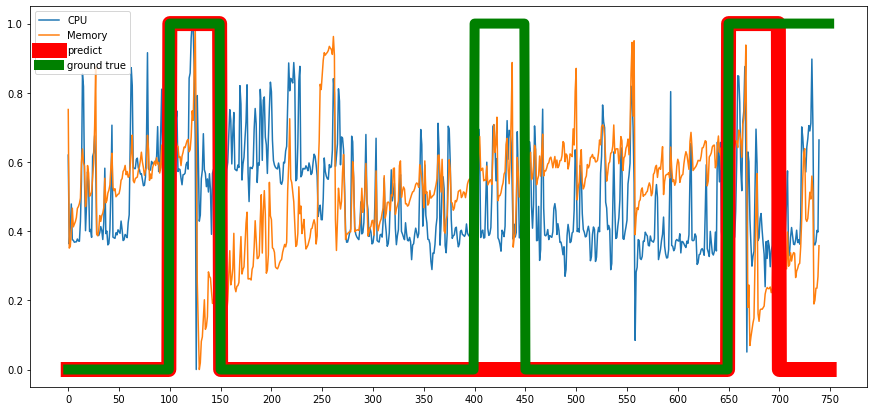

In [2]:
from IPython.core.pylabtools import figsize

figsize(15, 7) 

pre_list = []
exp_gt_list = []

for pre_label in anomaly_batch:
    if pre_label == 1:
        for i in range(detect_window_size):
            pre_list.append(1)
    else:
        for i in range(detect_window_size):
            pre_list.append(0)
            
for gt_label in gt_list:
    if gt_label == 1:
        for i in range(detect_window_size):
            exp_gt_list.append(1)
    else:
        for i in range(detect_window_size):
            exp_gt_list.append(0)



detection_columns = ["Memory used  (%)",
        "CPU utilization (%)"]

plt.plot(df["CPU utilization (%)"].values,label="CPU")
plt.plot(df["Memory used  (%)"].values,label="Memory")
plt.plot(pre_list,color="red",linewidth=15,label="predict")
plt.plot(exp_gt_list,color="green",linewidth=10,label="ground true")
plt.xticks(range(0,800,50))
plt.legend()

### Load Json Model

In [82]:


# Import the libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt  
import pandas as pd
from numpy import loadtxt
from tensorflow.keras.models import load_model,save_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation,Flatten,Input
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
import math,json,os,random,itertools
import time,traceback
from scipy import stats
random.seed(2)
#my scaler
import predict_utils
#read pre-trained scaler
from pickle import load
import tcn
from tcn import TCN 
from bokeh.plotting import figure, show
import json 

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean
def kl_divergence(mu, log_var):
    return -0.5 * K.sum(1 + log_var - K.exp(log_var) - K.square(mu), axis=-1,)
def build_kls_scores(encoder, X):
    """Get the KL-divergence scores across from a trained VAE encoder.
 
    Parameters
    ===========
    encoder : TenorFlow model
        Encoder of the VAE
    
    X : tensor
        data that KL-div. scores will be calculated from

    Returns
    ===========
    kls : numpy array
        Returns the KL-divergence scores as a numpy array
    """
    codings_mean, codings_log_var, codings = encoder.predict(X)
    kls = np.array(kl_divergence(codings_mean, codings_log_var))
    return kls

#pd.set_option('mode.chained_assignment', None)

anomaly_threshold = 5.
tolerance = 2
detection_columns = ["Memory used  (%)",
        "CPU utilization (%) "]

try:
    # Load the scaler
    scaler = load(open('6v_minmax_scaler.pkl', 'rb'))
    print("load scaler")  
except:
    print("loading scaler error")
bvae_model="./Model/best_model/20220101-174647_bvae/model.json"
bvae_weight="./Model/best_model/20220101-174647_bvae/weights.h5"
encoder_model="./Model/best_model/20220101-174647_encoder/model.json"
encoder_weight="./Model/best_model/20220101-174647_encoder/weights.h5"


with open(bvae_model, 'r') as json_file:
    json_savedModel= json_file.read()
with open(encoder_model, 'r') as json_file:
    json_savedEncoder= json_file.read()
    
#load the model architecture 
predict_model = tf.keras.models.model_from_json(json_savedModel,custom_objects={"TCN":TCN,"Sampling": Sampling})
predict_model.load_weights(bvae_weight)

predict_encoder = tf.keras.models.model_from_json(json_savedEncoder,custom_objects={"TCN":TCN,"Sampling": Sampling})
predict_encoder.load_weights(encoder_weight)


#Read CSV 
def read_data(path,o_dtname="Datetime",c_dtname = 'datetime'):
    df = pd.read_csv(path, sep=',', 
                     parse_dates={c_dtname:[o_dtname]}, 
                     infer_datetime_format=True, 
                     low_memory=False, 
                     na_values=['nan','?'], 
                     index_col=c_dtname)
    
    print(df.isnull().sum())
    return df


#caculate mape
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#caculate and return rmse,mae,mape
def cal_score(y_real,y_hat):
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error,mean_squared_error
    import math

    MAEScore = mean_absolute_error(y_real,y_hat)
    MSEScore = mean_squared_error(y_real,y_hat)
    RMSEScore = math.sqrt(mean_squared_error(y_real,y_hat))
    

    return MAEScore,MSEScore,RMSEScore


#read test df
df = read_data("test_df.csv",o_dtname="dt",c_dtname = 'datetime')
print(df)

#split data into size=100 batch
detect_window_size = 50
df_list = []
gt_list = []
for i in range(0,df.shape[0],detect_window_size):
    
    if df.iloc[i:i+detect_window_size].shape[0] == detect_window_size:
        df_list.append(df.iloc[i:i+detect_window_size,:])
        if np.sum(df.iloc[i:i+detect_window_size,-1].values)>=1:
            gt_list.append(1)
        else:
            gt_list.append(0)
    else:
        print("tail")
        
        df_list.append(df.iloc[-detect_window_size:,:])
        if np.sum(df.iloc[-detect_window_size:,-1].values)>=1:
            gt_list.append(1)
        else:
            gt_list.append(0)
        break

print(*gt_list)


#split data into size=100 batch

#predict_count: a pointer, if pointer >=  len(list) then Waiting the new data
#window_size: capture time series features using sliding window
#df_list: variables that temporarily store real-time data  
predict_count = 0
window_size = predict_model.layers[0].input_shape[0][1]
error_sum_list=[]
failure_bitmap = []
rmse_list = []
mae_list = []
anomaly_batch = []
loss_list = []
enc_list = []


#for each batch
for i,df_batch in enumerate(df_list):
    #print(df_batch.head())
    #for each windows
    print("{}th batch".format(i))
    anomaly_list = []
    for j in range(0,df_batch.shape[0]-window_size):
        pre_batch = np.expand_dims(df_list[predict_count].iloc[j:j+window_size,:-1].values,axis=0)
        #print(pre_batch)
        
        pre = predict_model.predict(pre_batch)
        encoder_pre = build_kls_scores(predict_encoder,pre_batch)
        pre[0] = scaler.inverse_transform(pre[0])
        pre_batch[0] = scaler.inverse_transform(pre_batch[0])
        enc_list.append(encoder_pre)
        mae,mse,rmse= cal_score(pre_batch[0,:,:],pre[0,:,:])
        loss_list.append([mae,mse,rmse])
        #print(mae)
        #print(mae)
        if encoder_pre >= 0.02:
            anomaly_list.append(1)
            #plt.plot(pre_batch[0,:,0])
            #plt.plot(pre[0,:,0])
            #plt.show()
        else:
            anomaly_list.append(0)
        #os.system("cls")
        
    #print(*anomaly_list)
    #print(sum(anomaly_list))
    error_sum_list.append(sum(anomaly_list))
    predict_count+=1
    #print(sum(anomaly_list))


    if sum(anomaly_list)>=tolerance:
        anomaly_batch.append(1)
    else:
        anomaly_batch.append(0)
    #os.system("cls")


#print(*anomaly_batch) 
#print(*error_sum_list)  

result_dict = {
    "predict":anomaly_batch,
    "ground true":gt_list,
    "windows error":error_sum_list

}
loss_dict = {
    "MAE":np.array(loss_list)[:,0],
    "MSE":np.array(loss_list)[:,1],
    "RMSE":np.array(loss_list)[:,2],
    "Encoder":np.array(enc_list)[:,0]

}
res_df = pd.DataFrame(result_dict)
res_df.to_csv("vae_test_res.csv")

loss_df = pd.DataFrame(loss_dict)                 
loss_df.to_csv("vae_test_loss.csv")


load scaler
CPU utilization (%)    0
Memory used  (%)       0
C_anomaly_label        0
dtype: int64
                     CPU utilization (%)  Memory used  (%)  C_anomaly_label
datetime                                                                   
2021-10-25 12:00:00             0.619872          0.751620                0
2021-10-25 12:03:00             0.362755          0.350977                0
2021-10-25 12:06:00             0.409731          0.355691                0
2021-10-25 12:09:00             0.478531          0.399189                0
2021-10-25 12:12:00             0.375117          0.466420                0
...                                  ...               ...              ...
2021-10-27 00:45:00             0.360103          0.200533                0
2021-10-27 00:48:00             0.369827          0.234972                0
2021-10-27 00:51:00             0.402045          0.235262                0
2021-10-27 00:54:00             0.397626          0.268535      

In [76]:
np.array(loss_list).shape

(510, 3)

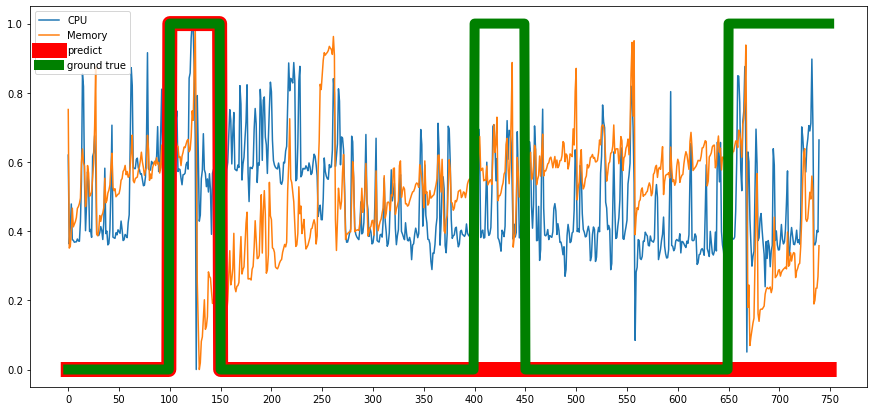

In [83]:
from IPython.core.pylabtools import figsize

figsize(15, 7) 

pre_list = []
exp_gt_list = []

for pre_label in anomaly_batch:
    if pre_label == 1:
        for i in range(detect_window_size):
            pre_list.append(1)
    else:
        for i in range(detect_window_size):
            pre_list.append(0)
            
for gt_label in gt_list:
    if gt_label == 1:
        for i in range(detect_window_size):
            exp_gt_list.append(1)
    else:
        for i in range(detect_window_size):
            exp_gt_list.append(0)



detection_columns = ["Memory used  (%)",
        "CPU utilization (%)"]

plt.plot(df["CPU utilization (%)"].values,label="CPU")
plt.plot(df["Memory used  (%)"].values,label="Memory")
plt.plot(pre_list,color="red",linewidth=15,label="predict")
plt.plot(exp_gt_list,color="green",linewidth=10,label="ground true")
plt.xticks(range(0,800,50))
plt.legend()

### Other

In [32]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = predict_model.predict_on_batch(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# method II: ggplot
from ggplot import *
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')

ValueError: y should be a 1d array, got an array of shape (723, 2) instead.

In [21]:
df["CPU utilization (%)"].values

array([75.5006, 75.5006, 75.5006, ..., 88.7102, 88.7102, 88.7102])

In [9]:
loss_list[0:][1]

[0.5225223539662132, 0.514062852660365, 0.716981765919026]

In [44]:
def concate_data(data):

    mem_data = np.concatenate([data[:,:,0],data[:,:,1],data[:,:,2],data[:,:,3]]).reshape(-1,X_WIN,1)
    cpu_data = np.concatenate([data[:,:,4],data[:,:,5],data[:,:,6],data[:,:,7]]).reshape(-1,X_WIN,1)
    return np.concatenate([mem_data,cpu_data],axis=2)

X_train = concate_data(X_train)
X_test = concate_data(X_test)

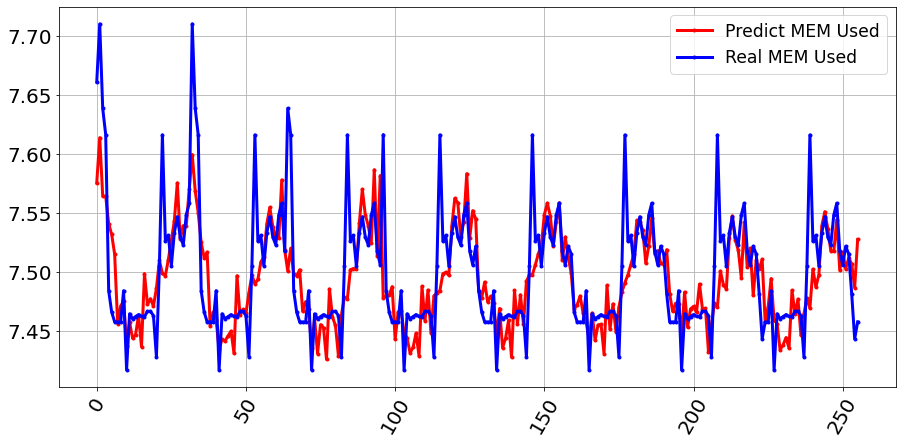

In [ ]:
plt.plot(x_hat[:,0].flatten()[:256],color = 'red',marker='.', label = 'Predict MEM Used',linewidth=3)
plt.plot(x[:,0].flatten()[:256],color = 'blue',marker='.', label = 'Real MEM Used',linewidth=3)
plt.xticks(fontsize=20,rotation=60)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(fontsize='xx-large')
#plt.title('Predicted values and actual values on test data',fontsize=20)
plt.show()

In [44]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def cal_score(y_real,y_hat,model_name):
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    import math

    MAEScore = mean_absolute_error(y_real,y_hat)
    RMSEScore = math.sqrt(mean_squared_error(y_real,y_hat))
    MAPEScore = mean_absolute_percentage_error(y_real,y_hat)
        
    print("Model,MAE,RMSE,MAPE")
    print("{},{},{},{}".format(model_name,round(MAEScore,3),round(RMSEScore,3),round(MAPEScore,3)))
    
    
    return round(MAEScore,3),round(RMSEScore,3),round(MAPEScore,3)

MAE,RMSE,MAPE = cal_score(x,x_hat,"Conv")
MAE,RMSE,MAPE = cal_score(x,x_hat,"TCN")

Conv
MAE:0.15
RMSE:0.527
MAPE:4.775
